In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re
from string import punctuation
from nltk.tokenize import ToktokTokenizer
from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
import os

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout
from sklearn.preprocessing import  MultiLabelBinarizer
import sklearn.datasets as skds
from pathlib import Path
import itertools
from sklearn.metrics import confusion_matrix

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# to read dataset using pandas
def load_data(path):
  return pd.read_csv(path, encoding="ISO-8859-1")

# to get dataset after merging questions data and tags
def get_dataset():
  question_path ="/content/drive/My Drive/NLP-Classification-project/data/Questions.csv"
  tags_path = "/content/drive/My Drive/NLP-Classification-project/data/Tags.csv"
  
  # questions data operations
  question_data = load_data(question_path)
  question_data.drop(columns=['OwnerUserId', 'CreationDate', 'ClosedDate'], inplace=True)  # dropping unwanted columns 
 
  # tags data operations
  tags_data = load_data(tags_path)
  tags_data['Tag'] = tags_data['Tag'].astype(str)                                           # converting to type string 
  grouped_tags = tags_data.groupby("Id")['Tag'].apply(lambda tags: ' '.join(tags))          # grouping tags based on ID's 
  grouped_tags_final = pd.DataFrame({'Id':grouped_tags.index, 'Tags':grouped_tags.values})  # converting series to dataframe
  
  data = question_data.merge(grouped_tags_final, on='Id')                                   # merging questions and tags

  return data



In [4]:
data = get_dataset()
data

,Id,Score,Title,Body,Tags
0,80,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,90,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,120,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,180,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,260,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction
...,...,...,...,...,...
1264211,40143210,0,URL routing in PHP (MVC),<p>I am building a custom MVC project and I ha...,php .htaccess
1264212,40143300,0,Bigquery.Jobs.Insert - Resumable Upload?,<p>The API docs show that you should be able t...,google-bigquery
1264213,40143340,1,Obfuscating code in android studio,<p>Under minifyEnabled I changed from false to...,android android-studio
1264214,40143360,0,How to fire function after v-model change?,<p>I have input which I use to filter my array...,javascript vue.js


In [5]:
type(data)

pandas.core.frame.DataFrame

In [6]:
data['Tags'] = data['Tags'].apply(lambda x: x.split())

In [7]:
data["tag_count"] = data["Tags"].apply(len)

In [8]:
class Tags:
  def __init__(self,dataset):
    self.data =  dataset
    self.all_tags = [item for sublist in dataset['Tags'].values for item in sublist]
    self.unique_tags = list(set(self.all_tags))
    self.keywords = nltk.FreqDist(self.all_tags)


  def all_tags_counts(self):
    print("Total no.of tags in dataset: "+str(len(self.all_tags)))

  def unique_tag_count(self):
    print("Unique no.of tags in dataset: "+str(len(self.unique_tags)))

  def get_common_features(self,frequency):
    frequencies_words = self.keywords.most_common(frequency)
    return frequencies_words

  def plot_top_frequencies(self,frequency):
    fig, ax = plt.subplots(figsize=(10, 7))
    self.keywords.plot(frequency, cumulative=False)

  def wordcount(self,frequency):
    tags_features = [word[0] for word in self.get_common_features(frequency)]
    tags_string = ' '.join(tags_features).lower()
    wordcloud = WordCloud(max_font_size=50, max_words=100).generate(tags_string)
    plt.figure(figsize=(15,7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

  def frequency_pie(self,frequency):
    common_features = self.get_common_features(frequency)
    tags_features = [word[0] for word in common_features]
    tags_frequency = [word[1] for word in common_features]
    fig = plt.figure(figsize =(10, 7))
    plt.pie(tags_frequency, labels = tags_features)
    plt.show()

  def freq(self):
    t_fre = [0,0,0,0,0]
    for item in self.data['tag_count']:
      t_fre[item-1]+=1
    t_lab = [1,2,3,4,5]
    fig = plt.figure(figsize =(10, 7))
    plt.pie(t_fre,labels = t_lab, autopct='%1.1f%%', explode=[0.1,0.1,0.2,0.1,0.1], shadow=True, startangle=90)
    plt.title('length of tags')
    plt.show()




In [9]:
tags = Tags(data)
tags.all_tags_counts()
tags.unique_tag_count()

Total no.of tags in dataset: 3750994
Unique no.of tags in dataset: 37035


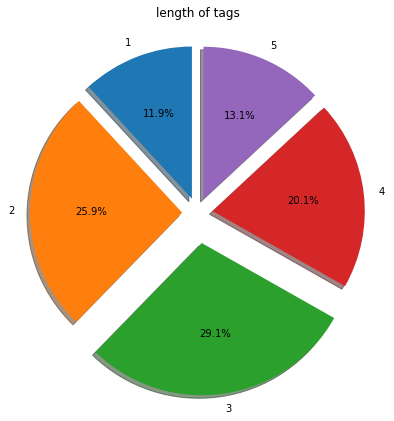

In [ ]:
tags.freq()

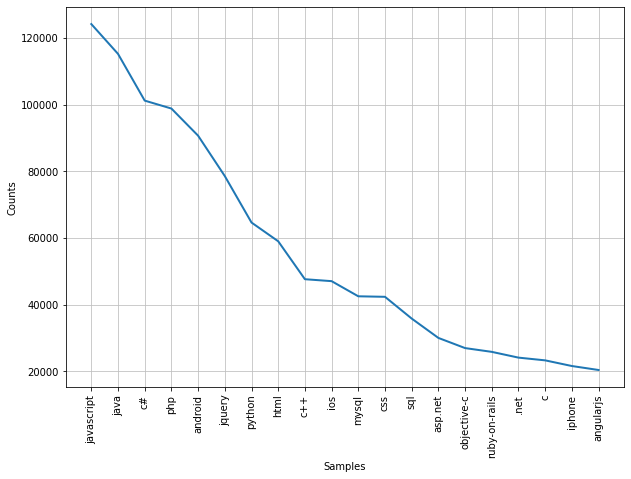

In [ ]:
tags.plot_top_frequencies(20)

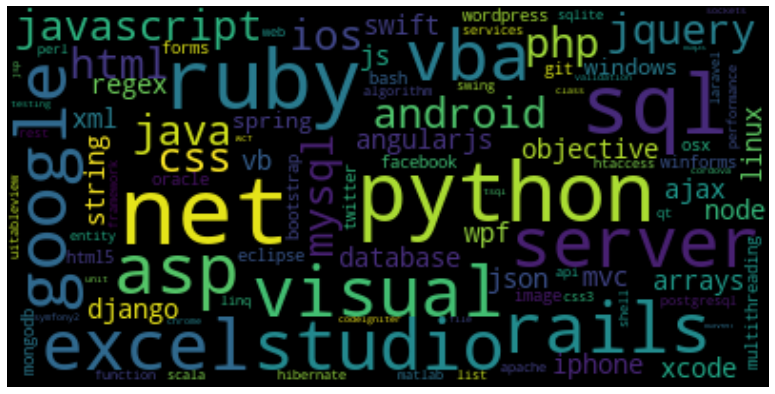

In [ ]:
tags.wordcount(100)


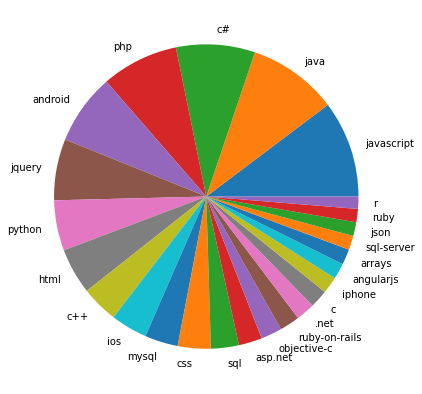

In [ ]:
tags.frequency_pie(25)

In [10]:
tags_features = [word[0] for word in tags.get_common_features(100)]

In [ ]:
data

,Id,Score,Title,Body,Tags,tag_count
0,80,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,"[flex, actionscript-3, air]",3
1,90,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,"[svn, tortoisesvn, branch, branching-and-merging]",4
2,120,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"[sql, asp.net, sitemap]",3
3,180,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,"[algorithm, language-agnostic, colors, color-s...",4
4,260,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"[c#, .net, scripting, compiler-construction]",4
...,...,...,...,...,...,...
1264211,40143210,0,URL routing in PHP (MVC),<p>I am building a custom MVC project and I ha...,"[php, .htaccess]",2
1264212,40143300,0,Bigquery.Jobs.Insert - Resumable Upload?,<p>The API docs show that you should be able t...,[google-bigquery],1
1264213,40143340,1,Obfuscating code in android studio,<p>Under minifyEnabled I changed from false to...,"[android, android-studio]",2
1264214,40143360,0,How to fire function after v-model change?,<p>I have input which I use to filter my array...,"[javascript, vue.js]",2


In [17]:
data["Score"].max()

5190

In [18]:
def drop_WRT_score(score,data):
  data = data[data['Score']>score]
  data.drop(columns=['Id', 'Score','tag_count'], inplace=True)
  return data

In [19]:
data = drop_WRT_score(20,data)
data

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Title,Body,Tags
0,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,"[flex, actionscript-3, air]"
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,"[svn, tortoisesvn, branch, branching-and-merging]"
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"[sql, asp.net, sitemap]"
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,"[algorithm, language-agnostic, colors, color-s..."
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"[c#, .net, scripting, compiler-construction]"
...,...,...,...
1235494,Strange Java behaviour with static and final q...,<p>In our team we found some strange behaviour...,"[java, order, final]"
1238365,SMTP configuration not working in production,<p>I'm trying to send an email when a form is ...,"[php, email, smtp, phpmailer]"
1240566,"Since Xcode 8 and iOS10, views are not sized p...","<p>It seems that with Xcode 8, on <code>viewDi...","[ios, autolayout, ios10, xcode8]"
1243077,What precautions should I take to make a memor...,"<p>My initial problem is that I have, on a pro...","[c, language-lawyer, undefined-behavior, c11, ..."


In [20]:
token=ToktokTokenizer()

In [21]:
data["question"] = data["Title"]+" "+data["Body"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [22]:
def remove_HTMLformat():
  data['question'] = data['question'].apply(lambda x: BeautifulSoup(x).get_text()) 

In [23]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r"\'\n", " ", text)
    text = re.sub(r"\'\xa0", " ", text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

In [24]:
def strip_list_noempty(mylist):
    newlist = (item.strip() if hasattr(item, 'strip') else item for item in mylist)
    return [item for item in newlist if item != '']

In [25]:
def clean_punct(text): 
    words=token.tokenize(text)
    punctuation_filtered = []
    regex = re.compile('[%s]' % re.escape(punctuation))
    remove_punctuation = str.maketrans(' ', ' ', punctuation)
    for w in words:
        if w in tags_features:
            punctuation_filtered.append(w)
        else:
            punctuation_filtered.append(regex.sub('', w))
  
    filtered_list = strip_list_noempty(punctuation_filtered)
        
    return ' '.join(map(str, filtered_list))

In [26]:
def lemitizeWords(text):
  lemma=WordNetLemmatizer()
  words=token.tokenize(text)
  listLemma=[]
  for w in words:
      x=lemma.lemmatize(w, pos="v")
      listLemma.append(x)
  return ' '.join(map(str, listLemma))


In [27]:
def stopWordsRemove(text):
  nltk.download('stopwords')
  stop_words = set(stopwords.words("english"))
  words=token.tokenize(text)
    
  filtered = [w for w in words if not w in stop_words]
    
  return ' '.join(map(str, filtered))

In [28]:
def reduce_data():
  remove_HTMLformat()
  data['question'] = data['question'].apply(lambda x: clean_text(x)) 
  nltk.download('wordnet')
  nltk.download('omw-1.4')
  data['question'] = data['question'].apply(lambda x: lemitizeWords(x)) 
  data['question'] = data['question'].apply(lambda x: stopWordsRemove(x)) 

In [29]:
reduce_data()
data

Streaming output truncated to the last 5000 lines.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-dat

,Title,Body,Tags,question
0,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,"[flex, actionscript-3, air]",sqlstatement.execute( ) - multiple query one s...
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,"[svn, tortoisesvn, branch, branching-and-merging]",good branch merge tutorials tortoisesvn ? real...
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"[sql, asp.net, sitemap]",asp.net site map anyone get experience create ...
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,"[algorithm, language-agnostic, colors, color-s...",function create color wheel something pseudo-s...
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"[c#, .net, scripting, compiler-construction]",add script functionality .net applications lit...
...,...,...,...,...
1235494,Strange Java behaviour with static and final q...,<p>In our team we found some strange behaviour...,"[java, order, final]",strange java behaviour static final qualifiers...
1238365,SMTP configuration not working in production,<p>I'm trying to send an email when a form is ...,"[php, email, smtp, phpmailer]",smtp configuration work production try send em...
1240566,"Since Xcode 8 and iOS10, views are not sized p...","<p>It seems that with Xcode 8, on <code>viewDi...","[ios, autolayout, ios10, xcode8]","since xcode 8 ios10 , view size properly viewd..."
1243077,What precautions should I take to make a memor...,"<p>My initial problem is that I have, on a pro...","[c, language-lawyer, undefined-behavior, c11, ...",precautions take make memory pool invoke undef...


In [ ]:
data.Title[0]

'SQLStatement.execute() - multiple queries in one statement'

In [ ]:
data.Body[0]

'<p>I\'ve written a database generation script in <a href="http://en.wikipedia.org/wiki/SQL">SQL</a> and want to execute it in my <a href="http://en.wikipedia.org/wiki/Adobe_Integrated_Runtime">Adobe AIR</a> application:</p>\n\n<pre><code>Create Table tRole (\n      roleID integer Primary Key\n      ,roleName varchar(40)\n);\nCreate Table tFile (\n    fileID integer Primary Key\n    ,fileName varchar(50)\n    ,fileDescription varchar(500)\n    ,thumbnailID integer\n    ,fileFormatID integer\n    ,categoryID integer\n    ,isFavorite boolean\n    ,dateAdded date\n    ,globalAccessCount integer\n    ,lastAccessTime date\n    ,downloadComplete boolean\n    ,isNew boolean\n    ,isSpotlight boolean\n    ,duration varchar(30)\n);\nCreate Table tCategory (\n    categoryID integer Primary Key\n    ,categoryName varchar(50)\n    ,parent_categoryID integer\n);\n...\n</code></pre>\n\n<p>I execute this in Adobe AIR using the following methods:</p>\n\n<pre><code>public static function RunSqlFromFile

In [ ]:
data.question[0]

'sqlstatement.execute( ) - multiple query one statement write database generation script sql want execute adobe air application : create table trole ( roleid integer primary key , rolename varchar( 40 ) ) ; create table tfile ( fileid integer primary key , filename varchar( 50 ) , filedescription varchar( 500 ) , thumbnailid integer , fileformatid integer , categoryid integer , isfavorite boolean , dateadded date , globalaccesscount integer , lastaccesstime date , downloadcomplete boolean , isnew boolean , isspotlight boolean , duration varchar( 30 ) ) ; create table tcategory ( categoryid integer primary key , categoryname varchar( 50 ) , parent_categoryid integer ) ; ... execute adobe air use follow methods : public static function runsqlfromfile( filename : string ) : void { var file : file = file.applicationdirectory.resolvepath( filename ) ; var stream : filestream = new filestream( ) ; stream.open( file , filemode.read ) var strsql : string = stream.readutfbytes( stream.bytesavai

In [ ]:
vocab_size = 15000

# Taking 80% data as training and remaining data as test.
split_percentage = int(len(data) * .8)

train_questions = data['question'][:split_percentage]
train_labels = data['Tags'][:split_percentage]

test_questions = data['question'][split_percentage:]
test_labels = data['Tags'][split_percentage:]


In [ ]:
test_labels

420109                               [http, http-pipelining]
420644                         [matplotlib, marker, scatter]
420693                  [maven, markdown, maven-site-plugin]
420708                                              [python]
420776                          [android, android-fragments]
                                 ...                        
1235494                                 [java, order, final]
1238365                        [php, email, smtp, phpmailer]
1240566                     [ios, autolayout, ios10, xcode8]
1243077    [c, language-lawyer, undefined-behavior, c11, ...
1248820                     [c++, c++11, variadic-templates]
Name: Tags, Length: 2823, dtype: object

In [ ]:
# define Tokenizer with Vocab Size
tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_questions)

x_train = tokenizer.texts_to_matrix(train_questions, mode='tfidf')
x_test = tokenizer.texts_to_matrix(test_questions, mode='tfidf')

# Encoding multiple labels using multi label binarizer
encoder =  MultiLabelBinarizer()
encoder.fit(train_labels)
y_train = encoder.transform(train_labels)
y_test = encoder.transform(test_labels)

In [ ]:
x_train.shape, y_train.shape

((11291, 15000), (11291, 5102))

In [ ]:
x_test[1].shape


(15000,)

In [ ]:
x_test[0].shape

(15000,)

In [ ]:
#Basic model creation
model = Sequential()
model.add(Dense(512, input_shape=(vocab_size,)))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(5102))
model.add(Activation('sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               7680512   
                                                                 
 activation (Activation)     (None, 512)               0         
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               2

In [ ]:

num_epochs =60
batch_size = 500
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=2,
                    validation_split=0.1)

Epoch 1/60
21/21 - 5s - loss: 0.1829 - accuracy: 0.0140 - val_loss: 0.0526 - val_accuracy: 0.0000e+00 - 5s/epoch - 226ms/step
Epoch 2/60
21/21 - 1s - loss: 0.0169 - accuracy: 0.0175 - val_loss: 0.0081 - val_accuracy: 0.0327 - 756ms/epoch - 36ms/step
Epoch 3/60
21/21 - 1s - loss: 0.0068 - accuracy: 0.0285 - val_loss: 0.0069 - val_accuracy: 0.0292 - 743ms/epoch - 35ms/step
Epoch 4/60
21/21 - 1s - loss: 0.0054 - accuracy: 0.0333 - val_loss: 0.0060 - val_accuracy: 0.0292 - 758ms/epoch - 36ms/step
Epoch 5/60
21/21 - 1s - loss: 0.0049 - accuracy: 0.0348 - val_loss: 0.0057 - val_accuracy: 0.0345 - 753ms/epoch - 36ms/step
Epoch 6/60
21/21 - 1s - loss: 0.0047 - accuracy: 0.0333 - val_loss: 0.0056 - val_accuracy: 0.0292 - 754ms/epoch - 36ms/step
Epoch 7/60
21/21 - 1s - loss: 0.0045 - accuracy: 0.0382 - val_loss: 0.0056 - val_accuracy: 0.0283 - 743ms/epoch - 35ms/step
Epoch 8/60
21/21 - 1s - loss: 0.0044 - accuracy: 0.0382 - val_loss: 0.0055 - val_accuracy: 0.0319 - 739ms/epoch - 35ms/step
Epoch 

In [ ]:
score, acc = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=2)

print('Test accuracy:', acc)
print("score: ",score)

6/6 - 0s - loss: 0.0040 - accuracy: 0.2774 - 168ms/epoch - 28ms/step
Test accuracy: 0.27736449241638184
score:  0.003961340058594942


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


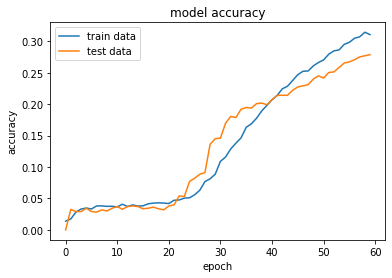

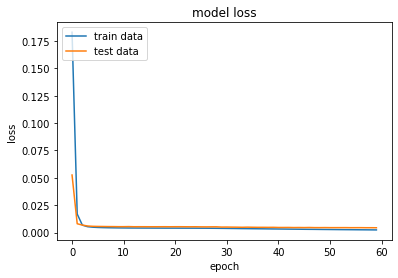

In [ ]:
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train data', 'test data'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train data', 'test data'], loc='upper left')
plt.show()

In [ ]:
import numpy as np
target_labels = encoder.classes_
for i in range(1,20):
    print()
    print("Actual label:",end=" ")
    print( test_labels.iloc[i])
    test_label = model.predict(np.array([x_test[i]]))
    print("Predicted label: ",end=" " )
    for i in range(3):
      j = np.argmax(test_label[0])
      predicted_label = target_labels[j]
      test_label[0][j] = 0;
      print(predicted_label, end = ", ")




Actual label: ['matplotlib', 'marker', 'scatter']
Predicted label:  python, matplotlib, numpy, 
Actual label: ['maven', 'markdown', 'maven-site-plugin']
Predicted label:  git, github, version-control, 
Actual label: ['python']
Predicted label:  python, generator, algorithm, 
Actual label: ['android', 'android-fragments']
Predicted label:  android, android-fragments, android-activity, 
Actual label: ['javascript', 'angularjs', 'checkbox', 'repeat']
Predicted label:  jquery, asp.net-mvc-3, asp.net-mvc, 
Actual label: ['html5', 'html5-audio']
Predicted label:  javascript, html, html5, 
Actual label: ['amazon-web-services', 'nosql', 'amazon-dynamodb']
Predicted label:  mysql, sql, database, 
Actual label: ['java', 'unit-testing', 'mockito']
Predicted label:  java, junit, multithreading, 
Actual label: ['java', 'collections']
Predicted label:  java, c#, collections, 
Actual label: ['ruby', 'string', 'substring', 'slice', 'idiomatic']
Predicted label:  ruby, regex, string, 
Actual label: ['

In [ ]:
def predict(str):
  test = tokenizer.texts_to_matrix([str], mode='tfidf')
  prediction = model.predict(np.array(test)) 
  print("text: "+ str)

  for i in range(3):
    j = np.argmax(prediction[0])
    predicted_label = target_labels[j]
    prediction[0][j] = 0;
    print("Predicted label: " + predicted_label)



 

In [ ]:
predict("Why is processing a sorted array faster than processing an unsorted array? Here is a piece of C++ code that shows some very peculiar behavior. For some strange reason, sorting the data (before the timed region) miraculously makes the loop almost six times faster.")

text: Why is processing a sorted array faster than processing an unsorted array? Here is a piece of C++ code that shows some very peculiar behavior. For some strange reason, sorting the data (before the timed region) miraculously makes the loop almost six times faster.
Predicted label: algorithm
Predicted label: string
Predicted label: c++


**Random Forest** **Classifier**

In [ ]:
reduced_df = data.head(2000)

In [ ]:
multilabel_binarizer = MultiLabelBinarizer()
encoded_labels = multilabel_binarizer.fit_transform(reduced_df['Tags'])

In [ ]:
encoded_labels.shape

(2000, 1643)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [ ]:
tfidfVectorizer = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       encoding = 'utf-8', 
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1643)



In [ ]:
X1_tfidf = tfidfVectorizer.fit_transform(reduced_df['question'])


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X1_tfidf, encoded_labels, test_size = 0.2, random_state = 0) # Do 80/20 split


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)



In [ ]:
from sklearn.metrics import hamming_loss
from sklearn.metrics import jaccard_score

# Function to get jacard score
def get_jacard():

    jscore = jaccard_score(y_test, y_pred, average='samples')
    
    return jscore

# Function to call jacard score and get hamming loss
def get_score(y_pred, clf):
    print("Clf: ", clf.__class__.__name__)
    print("Jacard score: {}".format(get_jacard()))
    print("Hamming loss: {}".format(hamming_loss(y_pred, y_test)*100))
     

In [ ]:
get_score()

Jacard score: 0.19258333333333333
Hamming loss: 0.155203895313451


In [ ]:
X_train.shape

(1600, 1643)

In [ ]:
y_pred.shape

(400, 1643)

**One Vs Rest**

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier




In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
sgdc = SGDClassifier()
logistic = LogisticRegression()



for clfs in [sgdc, logistic]:
    clf = OneVsRestClassifier(clfs)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    get_score(y_pred, clfs)

Clf:  SGDClassifier
Jacard score: 0.223922619047619
Hamming loss: 0.1605295191722459
Clf:  LogisticRegression
Jacard score: 0.03270833333333333
Hamming loss: 0.1757455873402313


**GRU**

In [ ]:

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences


tokenizer_object = Tokenizer()

tokenizer_object.fit_on_texts(train_questions) 

# padding the sequences
max_length = max([len(s.split()) for s in train_questions])

# define vocabulary size
vocab_size = len(tokenizer_object.word_index) + 1

X_train_questions =  tokenizer_object.texts_to_sequences(train_questions)
X_test_questions = tokenizer_object.texts_to_sequences(test_questions)


X_train_ques_pad = pad_sequences(X_train_questions, maxlen=max_length, padding='post')
X_test_ques_pad = pad_sequences(X_test_questions, maxlen=max_length, padding='post')

encoder = MultiLabelBinarizer()
encoder.fit(train_labels)
y_train = encoder.transform(train_labels)
y_test = encoder.transform(test_labels)

In [ ]:
#GRU model
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU
from keras.layers.embeddings import Embedding

EMBEDDING_DIM = 100

print('Build model...')

model1 = Sequential()
model1.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=max_length))
model1.add(GRU(units=32,  dropout=0.2, recurrent_dropout=0.2))
model1.add(Dense(5102, activation='relu'))

model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print('Summary of the built model...')
print(model1.summary())

Build model...
Summary of the built model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4686, 100)         4135100   
                                                                 
 gru (GRU)                   (None, 32)                12864     
                                                                 
 dense (Dense)               (None, 5102)              168366    
                                                                 
Total params: 4,316,330
Trainable params: 4,316,330
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
num_epochs = 2
batch_size = 100
history = model1.fit(X_train_ques_pad, y_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=2,
                    validation_split=0.2)

Epoch 1/2
91/91 - 843s - loss: 0.0069 - accuracy: 0.0371 - val_loss: 0.0073 - val_accuracy: 0.0274 - 843s/epoch - 9s/step
Epoch 2/2
91/91 - 910s - loss: 0.0069 - accuracy: 0.0261 - val_loss: 0.0073 - val_accuracy: 0.0274 - 910s/epoch - 10s/step


In [ ]:
score, acc = model1.evaluate(X_test_ques_pad, y_test,
                       batch_size=batch_size, verbose=2)

print('Test accuracy:', acc)
print("score: ",score)

29/29 - 31s - loss: 0.0061 - accuracy: 0.0305 - 31s/epoch - 1s/step
Test accuracy: 0.030464045703411102
score:  0.006063762586563826


In [ ]:
target_labels

array(['.bash-profile', '.doc', '.htaccess', ..., 'zsh-completion',
       'zshrc', 'zxing'], dtype=object)

In [ ]:
def predict(str):
  test =  tokenizer_object.texts_to_sequences([str])
  test1 = pad_sequences(test, maxlen=max_length, padding='post')

  # test = tokenizer.texts_to_matrix([str], mode='tfidf')
  prediction = model1.predict(np.array(test1)) 
  print("text: "+ str)

  for i in range(2):
    j = np.argmax(prediction[0])
    predicted_label = target_labels[j]
    prediction[0][j] = 0;
    print("Predicted label: " + predicted_label)



 

In [ ]:
predict("Why does it throw an IndexOutOfBoundsException")

text: Why does it throw an IndexOutOfBoundsException
Predicted label: java
Predicted label: c#


**LSTM**

In [ ]:

from keras.layers import SpatialDropout1D

EMBEDDING_DIM = 100

print('Build model...')

model2 = Sequential()
model2.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=max_length))
model2.add(SpatialDropout1D(0.2))
model2.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model2.add(Dense(5102, activation='relu'))

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print('Summary of the built model...')
print(model2.summary())

Build model...
Summary of the built model...
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 4686, 100)         4135100   
                                                                 
 spatial_dropout1d (SpatialD  (None, 4686, 100)        0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense_7 (Dense)             (None, 5102)              515302    
                                                                 
Total params: 4,730,802
Trainable params: 4,730,802
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
num_epochs = 2
batch_size = 100
history = model2.fit(X_train_ques_pad, y_train,
                    batch_size=batch_size,
                    epochs=num_epochs,
                    verbose=2,
                    validation_split=0.2)

Epoch 1/2
91/91 - 1751s - loss: 0.1634 - accuracy: 0.0308 - val_loss: 0.0114 - val_accuracy: 0.0288 - 1751s/epoch - 19s/step
Epoch 2/2
91/91 - 1779s - loss: 0.0085 - accuracy: 0.0466 - val_loss: 0.0068 - val_accuracy: 0.0288 - 1779s/epoch - 20s/step


In [ ]:
def predict(str):
  test =  tokenizer_object.texts_to_sequences([str])
  test1 = pad_sequences(test, maxlen=max_length, padding='post')

  # test = tokenizer.texts_to_matrix([str], mode='tfidf')
  prediction = model2.predict(np.array(test1)) 
  print("text: "+ str)

  for i in range(2):
    j = np.argmax(prediction[0])
    predicted_label = target_labels[j]
    prediction[0][j] = 0;
    print("Predicted label: " + predicted_label)



 

In [ ]:
predict("Why does it throw an IndexOutOfBoundsException")

text: Why does it throw an IndexOutOfBoundsException
Predicted label: c#
Predicted label: java


**BERT**(bert-base-uncased)

In [11]:
!pip install -q transformers

     |████████████████████████████████| 4.4 MB 8.1 MB/s 
     |████████████████████████████████| 596 kB 44.8 MB/s 
     |████████████████████████████████| 6.6 MB 43.6 MB/s 
     |████████████████████████████████| 101 kB 12.4 MB/s 


In [12]:
# Importing stock ml libraries
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import train_test_split

import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig

In [13]:
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 16
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 4
LEARNING_RATE = 1e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [30]:
dataset = data

In [31]:
dataset

,Title,Body,Tags,question
0,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,"[flex, actionscript-3, air]",sqlstatement.execute( ) - multiple query one s...
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,"[svn, tortoisesvn, branch, branching-and-merging]",good branch merge tutorials tortoisesvn ? real...
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"[sql, asp.net, sitemap]",asp.net site map anyone get experience create ...
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,"[algorithm, language-agnostic, colors, color-s...",function create color wheel something pseudo-s...
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"[c#, .net, scripting, compiler-construction]",add script functionality .net applications lit...
...,...,...,...,...
1235494,Strange Java behaviour with static and final q...,<p>In our team we found some strange behaviour...,"[java, order, final]",strange java behaviour static final qualifiers...
1238365,SMTP configuration not working in production,<p>I'm trying to send an email when a form is ...,"[php, email, smtp, phpmailer]",smtp configuration work production try send em...
1240566,"Since Xcode 8 and iOS10, views are not sized p...","<p>It seems that with Xcode 8, on <code>viewDi...","[ios, autolayout, ios10, xcode8]","since xcode 8 ios10 , view size properly viewd..."
1243077,What precautions should I take to make a memor...,"<p>My initial problem is that I have, on a pro...","[c, language-lawyer, undefined-behavior, c11, ...",precautions take make memory pool invoke undef...


In [32]:
import pandas as pd

lst = [item for sublist in data['Tags'].values for item in sublist]
df = pd.DataFrame([lst])
df.columns = [item for sublist in data['Tags'].values for item in sublist]
df

,flex,actionscript-3,air,svn,tortoisesvn,branch,branching-and-merging,sql,asp.net,sitemap,...,ios10,xcode8,c,language-lawyer,undefined-behavior,c11,strict-aliasing,c++,c++11,variadic-templates
0,flex,actionscript-3,air,svn,tortoisesvn,branch,branching-and-merging,sql,asp.net,sitemap,...,ios10,xcode8,c,language-lawyer,undefined-behavior,c11,strict-aliasing,c++,c++11,variadic-templates


In [33]:
tags1 = {}
for i in data["Tags"]:
    for j in i:
        if j not in tags1:
            tags1[j] = 1
        else:
            tags1[j] += 1

In [34]:
def to_1D(series):
 return pd.Series([x for _list in series for x in _list])

In [35]:
to_1D(data["Tags"]).value_counts()

java                   1338
c#                     1262
javascript             1153
android                1035
python                  870
                       ... 
vibration                 1
drupal-theming            1
svgz                      1
function-prototypes       1
lubridate                 1
Length: 6068, dtype: int64

In [36]:
tags_v1 = data["Tags"].apply(pd.Series)


In [37]:
tags_v1

,0,1,2,3,4
0,flex,actionscript-3,air,NaN,NaN
1,svn,tortoisesvn,branch,branching-and-merging,NaN
2,sql,asp.net,sitemap,NaN,NaN
3,algorithm,language-agnostic,colors,color-space,NaN
4,c#,.net,scripting,compiler-construction,NaN
...,...,...,...,...,...
1235494,java,order,final,NaN,NaN
1238365,php,email,smtp,phpmailer,NaN
1240566,ios,autolayout,ios10,xcode8,NaN
1243077,c,language-lawyer,undefined-behavior,c11,strict-aliasing


In [38]:
def boolean_df(item_lists, unique_items):
# Create empty dict
    bool_dict = {}
    
    # Loop through all the tags
    for i, item in enumerate(unique_items):
        
        # Apply boolean mask
        bool_dict[item] = item_lists.apply(lambda x: item in x)
            
    # Return the results as a dataframe
    return pd.DataFrame(bool_dict)

In [39]:
top10_tags_features = [word[0] for word in tags.get_common_features(10)]

In [40]:
tags_bool = boolean_df(data["Tags"], top10_tags_features)

In [41]:
tags_bool

,javascript,java,c#,php,android,jquery,python,html,c++,ios
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
1235494,False,True,False,False,False,False,False,False,False,False
1238365,False,False,False,True,False,False,False,False,False,False
1240566,False,False,False,False,False,False,False,False,False,True
1243077,False,False,False,False,False,False,False,False,False,False


In [42]:
dataset_final = data.join(tags_bool)

In [43]:
dataset_final

,Title,Body,Tags,question,javascript,java,c#,php,android,jquery,python,html,c++,ios
0,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,"[flex, actionscript-3, air]",sqlstatement.execute( ) - multiple query one s...,False,False,False,False,False,False,False,False,False,False
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,"[svn, tortoisesvn, branch, branching-and-merging]",good branch merge tutorials tortoisesvn ? real...,False,False,False,False,False,False,False,False,False,False
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"[sql, asp.net, sitemap]",asp.net site map anyone get experience create ...,False,False,False,False,False,False,False,False,False,False
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,"[algorithm, language-agnostic, colors, color-s...",function create color wheel something pseudo-s...,False,False,False,False,False,False,False,False,False,False
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"[c#, .net, scripting, compiler-construction]",add script functionality .net applications lit...,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1235494,Strange Java behaviour with static and final q...,<p>In our team we found some strange behaviour...,"[java, order, final]",strange java behaviour static final qualifiers...,False,True,False,False,False,False,False,False,False,False
1238365,SMTP configuration not working in production,<p>I'm trying to send an email when a form is ...,"[php, email, smtp, phpmailer]",smtp configuration work production try send em...,False,False,False,True,False,False,False,False,False,False
1240566,"Since Xcode 8 and iOS10, views are not sized p...","<p>It seems that with Xcode 8, on <code>viewDi...","[ios, autolayout, ios10, xcode8]","since xcode 8 ios10 , view size properly viewd...",False,False,False,False,False,False,False,False,False,True
1243077,What precautions should I take to make a memor...,"<p>My initial problem is that I have, on a pro...","[c, language-lawyer, undefined-behavior, c11, ...",precautions take make memory pool invoke undef...,False,False,False,False,False,False,False,False,False,False


In [44]:
df1=dataset_final.drop(dataset_final.index[1597:])
df1

,Title,Body,Tags,question,javascript,java,c#,php,android,jquery,python,html,c++,ios
0,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,"[flex, actionscript-3, air]",sqlstatement.execute( ) - multiple query one s...,False,False,False,False,False,False,False,False,False,False
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,"[svn, tortoisesvn, branch, branching-and-merging]",good branch merge tutorials tortoisesvn ? real...,False,False,False,False,False,False,False,False,False,False
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"[sql, asp.net, sitemap]",asp.net site map anyone get experience create ...,False,False,False,False,False,False,False,False,False,False
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,"[algorithm, language-agnostic, colors, color-s...",function create color wheel something pseudo-s...,False,False,False,False,False,False,False,False,False,False
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"[c#, .net, scripting, compiler-construction]",add script functionality .net applications lit...,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11358,Is there a JQuery plugin which combines Dragga...,<p>I'm looking to implement a web interface wi...,"[jquery, html, draggable]",jquery plugin combine draggable selectable loo...,False,False,False,False,False,True,False,True,False,False
11381,How can I change the image displayed in an UII...,<p>I have an <code>IBOutlet</code> to an <code...,"[iphone, uiimageview]",change image display uiimageview programmatica...,False,False,False,False,False,False,False,False,False,False
11394,Load WPF styles or other Static Resources from...,<p>I have a few WPF applications and I want al...,"[wpf, xaml, assemblies, styles, resourcedictio...",load wpf style static resources external file ...,False,False,False,False,False,False,False,False,False,False
11403,"In Python how can I access ""static"" class vari...",<p>If I have the following python code:</p>\n\...,[python],"python access "" static "" class variables withi...",False,False,False,False,False,False,True,False,False,False


In [45]:
dataset_final['target_list'] = dataset_final[[label for label in dataset_final.columns if label not in ['Title', 'Body','Tags','question']]].values.tolist()

In [46]:
dataset_final

,Title,Body,Tags,question,javascript,java,c#,php,android,jquery,python,html,c++,ios,target_list
0,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,"[flex, actionscript-3, air]",sqlstatement.execute( ) - multiple query one s...,False,False,False,False,False,False,False,False,False,False,"[False, False, False, False, False, False, Fal..."
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,"[svn, tortoisesvn, branch, branching-and-merging]",good branch merge tutorials tortoisesvn ? real...,False,False,False,False,False,False,False,False,False,False,"[False, False, False, False, False, False, Fal..."
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"[sql, asp.net, sitemap]",asp.net site map anyone get experience create ...,False,False,False,False,False,False,False,False,False,False,"[False, False, False, False, False, False, Fal..."
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,"[algorithm, language-agnostic, colors, color-s...",function create color wheel something pseudo-s...,False,False,False,False,False,False,False,False,False,False,"[False, False, False, False, False, False, Fal..."
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"[c#, .net, scripting, compiler-construction]",add script functionality .net applications lit...,False,False,True,False,False,False,False,False,False,False,"[False, False, True, False, False, False, Fals..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1235494,Strange Java behaviour with static and final q...,<p>In our team we found some strange behaviour...,"[java, order, final]",strange java behaviour static final qualifiers...,False,True,False,False,False,False,False,False,False,False,"[False, True, False, False, False, False, Fals..."
1238365,SMTP configuration not working in production,<p>I'm trying to send an email when a form is ...,"[php, email, smtp, phpmailer]",smtp configuration work production try send em...,False,False,False,True,False,False,False,False,False,False,"[False, False, False, True, False, False, Fals..."
1240566,"Since Xcode 8 and iOS10, views are not sized p...","<p>It seems that with Xcode 8, on <code>viewDi...","[ios, autolayout, ios10, xcode8]","since xcode 8 ios10 , view size properly viewd...",False,False,False,False,False,False,False,False,False,True,"[False, False, False, False, False, False, Fal..."
1243077,What precautions should I take to make a memor...,"<p>My initial problem is that I have, on a pro...","[c, language-lawyer, undefined-behavior, c11, ...",precautions take make memory pool invoke undef...,False,False,False,False,False,False,False,False,False,False,"[False, False, False, False, False, False, Fal..."


In [47]:
df2 = dataset_final[['question', 'target_list']].copy()
df2

,question,target_list
0,sqlstatement.execute( ) - multiple query one s...,"[False, False, False, False, False, False, Fal..."
1,good branch merge tutorials tortoisesvn ? real...,"[False, False, False, False, False, False, Fal..."
2,asp.net site map anyone get experience create ...,"[False, False, False, False, False, False, Fal..."
3,function create color wheel something pseudo-s...,"[False, False, False, False, False, False, Fal..."
4,add script functionality .net applications lit...,"[False, False, True, False, False, False, Fals..."
...,...,...
1235494,strange java behaviour static final qualifiers...,"[False, True, False, False, False, False, Fals..."
1238365,smtp configuration work production try send em...,"[False, False, False, True, False, False, Fals..."
1240566,"since xcode 8 ios10 , view size properly viewd...","[False, False, False, False, False, False, Fal..."
1243077,precautions take make memory pool invoke undef...,"[False, False, False, False, False, False, Fal..."


In [48]:
# df2.drop(columns=["index"], inplace=True)
df2 = df2.reset_index()
for i in range(len(df2.target_list)):
  if True in df2.target_list[i]:
    for j in range(len(df2.target_list[i])):
      df2.target_list[i][j] = int(df2.target_list[i][j])
  else:
    df2.drop([i], axis=0, inplace=True)
df2 = df2.reset_index()

In [49]:
df2

,level_0,index,question,target_list
0,4,4,add script functionality .net applications lit...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
1,5,5,use nest class case ? work collection class us...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
2,7,8,automatically update version number would like...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
3,8,10,connect database loop recordset c# ? simplest ...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
4,9,12,delete file lock another process c# ? look way...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
...,...,...,...,...
7748,14108,1233496,"num++ atomic ' int num ' ? general , int num ,...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]"
7749,14109,1235494,strange java behaviour static final qualifiers...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
7750,14110,1238365,smtp configuration work production try send em...,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
7751,14111,1240566,"since xcode 8 ios10 , view size properly viewd...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"


In [50]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [51]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [52]:
# Sections of config

# Defining some key variables that will be used later on in the training
MAX_LEN = 16
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 4
LEARNING_RATE = 1e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [53]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.title = dataframe['question']
        self.targets = self.data.target_list
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())

        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [54]:
train_size = 0.8
train_dataset = df2.sample(frac=train_size,random_state=200)
valid_dataset = df2.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(df2.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(valid_dataset.shape))

training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN)
validation_set = CustomDataset(valid_dataset, tokenizer, MAX_LEN)

FULL Dataset: (7753, 4)
TRAIN Dataset: (6202, 4)
TEST Dataset: (1551, 4)


In [55]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
validation_loader = DataLoader(validation_set, **test_params)

In [56]:
len(training_loader)

194

In [57]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 10)
    
    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids,return_dict=False)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = BERTClass()
model.to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

In [58]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [59]:
len(training_loader)

194

In [62]:
#to use as global variables
val_targets=[]
val_outputs=[] 

In [63]:
def train_model(start_epochs,  n_epochs, valid_loss_min_input, 
                training_loader, validation_loader, model, 
                optimizer):
   
  # initialize tracker for minimum validation loss
  valid_loss_min = valid_loss_min_input 
   
 
  for epoch in range(start_epochs, n_epochs+1):
    train_loss = 0
    valid_loss = 0

    model.train()
    print('############# Epoch {}: Training Start   #############'.format(epoch))
    for batch_idx, data in enumerate(training_loader):
        #print('yyy epoch', batch_idx)
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        #if batch_idx%5000==0:
         #   print(f'Epoch: {epoch}, Training Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #print('before loss data in training', loss.item(), train_loss)
        train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.item() - train_loss))
        #print('after loss data in training', loss.item(), train_loss)
    
    print('############# Epoch {}: Training End     #############'.format(epoch))
    
    print('############# Epoch {}: Validation Start   #############'.format(epoch))
    ######################    
    # validate the model #
    ######################
 
    model.eval()
   
    with torch.no_grad():
      for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.item() - valid_loss))
            val_targets.extend(targets.cpu().detach().numpy().tolist())
            val_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

      print('############# Epoch {}: Validation End     #############'.format(epoch))
      # calculate average losses
      #print('before cal avg train loss', train_loss)
      train_loss = train_loss/len(training_loader)
      valid_loss = valid_loss/len(validation_loader)
      # print training/validation statistics 
      print('Epoch: {} \tAvgerage Training Loss: {:.6f} \tAverage Validation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
      
      # create checkpoint variable and add important data
      checkpoint = {
            'epoch': epoch + 1,
            'valid_loss_min': valid_loss,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict()
      }
        
        # save checkpoint
      # save_ckp(checkpoint, False, checkpoint_path, best_model_path)
        
      ## TODO: save the model if validation loss has decreased
      if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,valid_loss))
        # save checkpoint as best model
        # save_ckp(checkpoint, True, checkpoint_path, best_model_path)
        valid_loss_min = valid_loss

    print('############# Epoch {}  Done   #############\n'.format(epoch))


  return model

In [67]:
# checkpoint_path = '/content/drive/My Drive/NLP-Classification-project/current_checkpoint.pt'
# best_model = '/content/drive/My Drive/NLP-Classification-project/best_model.pt'
trained_model = train_model(1, 4, np.Inf, training_loader, validation_loader, model, 
                      optimizer)

############# Epoch 1: Training Start   #############
############# Epoch 1: Training End     #############
############# Epoch 1: Validation Start   #############
############# Epoch 1: Validation End     #############
Epoch: 1 	Avgerage Training Loss: 0.000712 	Average Validation Loss: 0.002882
Validation loss decreased (inf --> 0.002882).  Saving model ...
############# Epoch 1  Done   #############

############# Epoch 2: Training Start   #############
############# Epoch 2: Training End     #############
############# Epoch 2: Validation Start   #############
############# Epoch 2: Validation End     #############
Epoch: 2 	Avgerage Training Loss: 0.000581 	Average Validation Loss: 0.002768
Validation loss decreased (0.002882 --> 0.002768).  Saving model ...
############# Epoch 2  Done   #############

############# Epoch 3: Training Start   #############
############# Epoch 3: Training End     #############
############# Epoch 3: Validation Start   #############
############# Epo

In [68]:
val_preds = (np.array(val_outputs) >= 0.5).astype(int)


In [69]:
accuracy = metrics.accuracy_score(val_targets, val_preds)
f1_score_micro = metrics.f1_score(val_targets, val_preds, average='micro')
f1_score_macro = metrics.f1_score(val_targets, val_preds, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.5527079303675049
F1 Score (Micro) = 0.6907317073170732
F1 Score (Macro) = 0.6753075044430766


In [ ]:
from sklearn.metrics import multilabel_confusion_matrix as mcm, classification_report


In [ ]:
print(classification_report(val_targets, val_preds))

              precision    recall  f1-score   support

           0       0.66      0.39      0.49      1012
           1       0.85      0.40      0.54      1112
           2       0.82      0.31      0.45      1040
           3       0.94      0.42      0.58       436
           4       0.91      0.70      0.79       896
           5       0.93      0.51      0.66       536
           6       0.92      0.62      0.74       668
           7       0.64      0.07      0.12       364
           8       0.89      0.41      0.56       564
           9       0.69      0.20      0.31       364

   micro avg       0.84      0.43      0.57      6992
   macro avg       0.83      0.40      0.53      6992
weighted avg       0.83      0.43      0.55      6992
 samples avg       0.25      0.25      0.25      6992



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**bert-base-cased**

In [ ]:
! pip install -q pytorch-lightning

In [ ]:
! pip install -q bs4
! pip install -q transformers

In [ ]:
# Import all libraries
import pandas as pd
import numpy as np
import re

# Huggingface transformers
import transformers
from transformers import BertModel,BertTokenizer,AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn ,cuda
from torch.utils.data import DataLoader,Dataset,RandomSampler, SequentialSampler

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

#handling html data
from bs4 import BeautifulSoup

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [ ]:
# load the stackoverflow questions dataset
df_questions = pd.read_csv('/content/drive/My Drive/NLP-Classification-project/data/Questions.csv',encoding="ISO-8859-1")

In [ ]:
# load the tags dataset
df_tags = pd.read_csv('/content/drive/My Drive/NLP-Classification-project/data/Tags.csv')

In [ ]:
def pre_process(text):

  text = BeautifulSoup(text).get_text()
  
  # fetch alphabetic characters
  text = re.sub("[^a-zA-Z]", " ", text)

  # convert text to lower case
  text = text.lower()

  # split text into tokens to remove whitespaces
  tokens = text.split()

  return " ".join(tokens)

In [ ]:
def drop_WRT_score(score,data):
  data = data[data['Score']>score]
  # data.drop(columns=['Id', 'Score','tag_count'], inplace=True)
  return data

In [ ]:
df_questions = drop_WRT_score(25,df_questions)

In [ ]:
df_questions

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...
5,330,63.0,2008-08-02T02:51:36Z,NaN,29,Should I use nested classes in this case?,<p>I am working on a collection of classes use...
...,...,...,...,...,...,...,...
1233496,39393850,4973224.0,2016-09-08T14:39:51Z,NaN,110,Can num++ be atomic for 'int num'?,"<p>In general, for <code>int num</code>, <code..."
1235494,39448160,1764889.0,2016-09-12T10:22:48Z,2016-09-13T18:00:35Z,75,Strange Java behaviour with static and final q...,<p>In our team we found some strange behaviour...
1240566,39578530,127493.0,2016-09-19T17:09:18Z,NaN,50,"Since Xcode 8 and iOS10, views are not sized p...","<p>It seems that with Xcode 8, on <code>viewDi..."
1243077,39640620,1934349.0,2016-09-22T13:35:53Z,NaN,27,What precautions should I take to make a memor...,"<p>My initial problem is that I have, on a pro..."


In [ ]:
# clean the text in Body column
df_questions['Clean_Body'] = df_questions['Body'].apply(pre_process)


In [ ]:
# count of unique tags
len(df_tags['Tag'].unique())

37035

In [ ]:
df_tags['Tag'].value_counts()[0:10]


javascript    124155
java          115212
c#            101186
php            98808
android        90659
jquery         78542
python         64601
html           58976
c++            47591
ios            47009
Name: Tag, dtype: int64

In [ ]:
# Consider only Top 10 tags - want to keep a smaller dataset
top_tags = df_tags['Tag'].value_counts().keys()[0:10]
top_tags

Index(['javascript', 'java', 'c#', 'php', 'android', 'jquery', 'python',
       'html', 'c++', 'ios'],
      dtype='object')

In [ ]:
# First group tags Id wise
df_tags = df_tags.groupby('Id').apply(lambda x:x['Tag'].values).reset_index(name='tags')
df_tags.head()

,Id,tags
0,80,"[flex, actionscript-3, air]"
1,90,"[svn, tortoisesvn, branch, branching-and-merging]"
2,120,"[sql, asp.net, sitemap]"
3,180,"[algorithm, language-agnostic, colors, color-s..."
4,260,"[c#, .net, scripting, compiler-construction]"


In [ ]:
# merge tags and questions datasets
df = pd.merge(df_questions,df_tags,how='inner',on='Id')

In [ ]:
# Retain only the columns we will use for training the model - Tags will be the label
df = df[['Clean_Body','tags']]
df.head()


,Clean_Body,tags
0,i ve written a database generation script in s...,"[flex, actionscript-3, air]"
1,are there any really good tutorials explaining...,"[svn, tortoisesvn, branch, branching-and-merging]"
2,this is something i ve pseudo solved many time...,"[algorithm, language-agnostic, colors, color-s..."
3,i have a little game written in c it uses a da...,"[c#, .net, scripting, compiler-construction]"
4,i am working on a collection of classes used f...,"[c++, oop, class, nested-class]"


In [ ]:
df_questions['Clean_Body'][1]

'are there any really good tutorials explaining branching and merging with apache subversion all the better if it s specific to tortoisesvn client'

In [ ]:
# Filter out records ( values in clean_body and tags) that have atleast one of the top tags

x=[] # To store the filtered clean_body values
y=[] # to store the corresponding tags
# Convert to list data type
lst_top_tags = list(top_tags)

for i in range(len(df['tags'])):
    temp=[]
    for tag in df['tags'][i]:
        if tag in lst_top_tags:
            temp.append(tag)

    if(len(temp)>0):
        x.append(df['Clean_Body'][i])
        y.append(temp)

In [ ]:
# number of records that will be used for training and testing
len(x)

5924

In [ ]:
# Encode the tags(labels) in a binary format in order to be used for training

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
 
yt = mlb.fit_transform(y)
yt.shape

(5924, 10)

In [ ]:
# Getting a sense of how the tags data looks like
print(yt[0])
print(mlb.inverse_transform(yt[0].reshape(1,-1)))
print(mlb.classes_)

[0 1 0 0 0 0 0 0 0 0]
[('c#',)]
['android' 'c#' 'c++' 'html' 'ios' 'java' 'javascript' 'jquery' 'php'
 'python']


In [ ]:
# compute no. of words in each question
questions = x
word_cnt = [len(quest.split()) for quest in questions]


In [ ]:
from sklearn.model_selection import train_test_split
# First Split for Train and Test
x_train,x_test,y_train,y_test = train_test_split(x, yt, test_size=0.1, random_state=RANDOM_SEED,shuffle=True)
# Next split Train in to training and validation
x_tr,x_val,y_tr,y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=RANDOM_SEED,shuffle=True)

In [ ]:
len(x_tr) ,len(x_val), len(x_test)


(4264, 1067, 593)

In [ ]:
class QTagDataset (Dataset):
    def __init__(self,quest,tags, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.text = quest
        self.labels = tags
        self.max_len = max_len
        
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, item_idx):
        text = self.text[item_idx]
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True, # Add [CLS] [SEP]
            max_length= self.max_len,
            padding = 'max_length',
            return_token_type_ids= False,
            return_attention_mask= True, # Differentiates padded vs normal token
            truncation=True, # Truncate data beyond max length
            return_tensors = 'pt' # PyTorch Tensor format
          )
        
        input_ids = inputs['input_ids'].flatten()
        attn_mask = inputs['attention_mask'].flatten()
        #token_type_ids = inputs["token_type_ids"]
        
        return {
            'input_ids': input_ids ,
            'attention_mask': attn_mask,
            'label': torch.tensor(self.labels[item_idx], dtype=torch.float)
            
        }
        

In [ ]:
class QTagDataModule (pl.LightningDataModule):
    
    def __init__(self,x_tr,y_tr,x_val,y_val,x_test,y_test,tokenizer,batch_size=16,max_token_len=100):
        super().__init__()
        self.tr_text = x_tr
        self.tr_label = y_tr
        self.val_text = x_val
        self.val_label = y_val
        self.test_text = x_test
        self.test_label = y_test
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.max_token_len = max_token_len

    def setup(self, stage=None):
        self.train_dataset = QTagDataset(quest=self.tr_text, tags=self.tr_label, tokenizer=self.tokenizer,max_len = self.max_token_len)
        self.val_dataset  = QTagDataset(quest=self.val_text,tags=self.val_label,tokenizer=self.tokenizer,max_len = self.max_token_len)
        self.test_dataset  = QTagDataset(quest=self.test_text,tags=self.test_label,tokenizer=self.tokenizer,max_len = self.max_token_len)
        
        
    def train_dataloader(self):
        return DataLoader (self.train_dataset,batch_size = self.batch_size,shuffle = True , num_workers=2)

    def val_dataloader(self):
        return DataLoader (self.val_dataset,batch_size= 16)

    def test_dataloader(self):
        return DataLoader (self.test_dataset,batch_size= 16)

In [ ]:
# Initialize the Bert tokenizer
BERT_MODEL_NAME = "bert-base-cased" 
Bert_tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)


In [ ]:
max_word_cnt = 100
quest_cnt = 0

# For every sentence...
for question in questions:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = Bert_tokenizer.encode(question, add_special_tokens=True)

    # Update the maximum sentence length.
    if len(input_ids) > max_word_cnt:
        quest_cnt +=1

print(f'# Question having word count > {max_word_cnt}: is  {quest_cnt}')

Token indices sequence length is longer than the specified maximum sequence length for this model (629 > 512). Running this sequence through the model will result in indexing errors


# Question having word count > 100: is  3034


In [ ]:
# Initialize the parameters that will be use for training
N_EPOCHS = 5
BATCH_SIZE = 32
MAX_LEN = 100
LR = 2e-05

In [ ]:
# Instantiate and set up the data_module
QTdata_module = QTagDataModule(x_tr,y_tr,x_val,y_val,x_test,y_test,Bert_tokenizer,BATCH_SIZE,MAX_LEN)
QTdata_module.setup()

In [ ]:
class QTagClassifier(pl.LightningModule):
    # Set up the classifier
    def __init__(self, n_classes=10, steps_per_epoch=None, n_epochs=3, lr=2e-5 ):
        super().__init__()

        self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
        self.classifier = nn.Linear(self.bert.config.hidden_size,n_classes) # outputs = number of labels
        self.steps_per_epoch = steps_per_epoch
        self.n_epochs = n_epochs
        self.lr = lr
        self.criterion = nn.BCEWithLogitsLoss()
        
    def forward(self,input_ids, attn_mask):
        output = self.bert(input_ids = input_ids ,attention_mask = attn_mask)
        output = self.classifier(output.pooler_output)
                
        return output
    
    
    def training_step(self,batch,batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        
        outputs = self(input_ids,attention_mask)
        loss = self.criterion(outputs,labels)
        self.log('train_loss',loss , prog_bar=True,logger=True)
        
        return {"loss" :loss, "predictions":outputs, "labels": labels }


    def validation_step(self,batch,batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        
        outputs = self(input_ids,attention_mask)
        loss = self.criterion(outputs,labels)
        self.log('val_loss',loss , prog_bar=True,logger=True)
        
        return loss
    
    def test_step(self,batch,batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['label']
        
        outputs = self(input_ids,attention_mask)
        loss = self.criterion(outputs,labels)
        self.log('test_loss',loss , prog_bar=True,logger=True)
        
        return loss
    
    
    def configure_optimizers(self):
        optimizer = AdamW(self.parameters() , lr=self.lr)
        warmup_steps = self.steps_per_epoch/3
        total_steps = self.steps_per_epoch * self.n_epochs - warmup_steps

        scheduler = get_linear_schedule_with_warmup(optimizer,warmup_steps,total_steps)

        return [optimizer], [scheduler]
    

In [ ]:
# Instantiate the classifier model
steps_per_epoch = len(x_tr)/BATCH_SIZE
model = QTagClassifier(n_classes=10, steps_per_epoch=steps_per_epoch,n_epochs=N_EPOCHS,lr=LR)
#

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
#Initialize Pytorch Lightning callback for Model checkpointing

# saves a file like: input/QTag-epoch=02-val_loss=0.32.ckpt
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',# monitored quantity
    filename='QTag-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3, #  save the top 3 models
    mode='min', # mode of the monitored quantity  for optimization
)

In [ ]:
# Instantiate the Model Trainer
trainer = pl.Trainer(max_epochs = N_EPOCHS , gpus = 1, callbacks=[checkpoint_callback],progress_bar_refresh_rate = 30)


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=30)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Trainer.
  f"Setting `Trainer(progress_bar_refresh_rate={progress_bar_refresh_rate})` is deprecated in v1.5 and"
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
trainer.fit(model, QTdata_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,

  | Name       | Type              | Params
-------------------------------------------------
0 | bert       | BertModel         | 108 M 
1 | classifier | Linear            | 7.7 K 
2 | criterion  | BCEWithLogitsLoss | 0     
-------------------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.272   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [ ]:
# Evaluate the model performance on the test dataset
trainer.test(model,datamodule=QTdata_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.3384649455547333
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.3384649455547333}]

In [ ]:
# Retreive the checkpoint path for best model
model_path = checkpoint_callback.best_model_path
model_path

'/content/lightning_logs/version_2/checkpoints/QTag-epoch=04-val_loss=0.34.ckpt'

In [ ]:
len(y_test), len(x_test)


(593, 593)

In [ ]:
# Size of Test set
print(f'Number of Questions = {len(x_test)}')

Number of Questions = 593


In [ ]:
from torch.utils.data import TensorDataset

# Tokenize all questions in x_test
input_ids = []
attention_masks = []


for quest in x_test:
    encoded_quest =  Bert_tokenizer.encode_plus(
                    quest,
                    None,
                    add_special_tokens=True,
                    max_length= MAX_LEN,
                    padding = 'max_length',
                    return_token_type_ids= False,
                    return_attention_mask= True,
                    truncation=True,
                    return_tensors = 'pt'      
    )
    
    # Add the input_ids from encoded question to the list.    
    input_ids.append(encoded_quest['input_ids'])
    # Add its attention mask 
    attention_masks.append(encoded_quest['attention_mask'])
    
# Now convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(y_test)

# Set the batch size.  
TEST_BATCH_SIZE = 64  

# Create the DataLoader.
pred_data = TensorDataset(input_ids, attention_masks, labels)
pred_sampler = SequentialSampler(pred_data)
pred_dataloader = DataLoader(pred_data, sampler=pred_sampler, batch_size=TEST_BATCH_SIZE)

In [ ]:
flat_pred_outs = 0
flat_true_labels = 0

In [ ]:
# Put model in evaluation mode
model = model.to(device) # moving model to cuda
model.eval()

# Tracking variables 
pred_outs, true_labels = [], []
#i=0
# Predict 
for batch in pred_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
  
    # Unpack the inputs from our dataloader
    b_input_ids, b_attn_mask, b_labels = batch
 
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        pred_out = model(b_input_ids,b_attn_mask)
        pred_out = torch.sigmoid(pred_out)
        # Move predicted output and labels to CPU
        pred_out = pred_out.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        #i+=1
        # Store predictions and true labels
        #print(i)
        #print(outputs)
        #print(logits)
        #print(label_ids)
    pred_outs.append(pred_out)
    true_labels.append(label_ids)

In [ ]:
pred_outs[0][0]

array([0.15329863, 0.20041478, 0.12367164, 0.10530708, 0.10257366,
       0.19930232, 0.17144407, 0.13208725, 0.10271975, 0.13550301],
      dtype=float32)

In [ ]:
# Combine the results across all batches. 
flat_pred_outs = np.concatenate(pred_outs, axis=0)

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)


In [ ]:
flat_true_labels

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0]])

In [ ]:
flat_pred_outs.shape , flat_true_labels.shape


((593, 10), (593, 10))

In [ ]:
#define candidate threshold values
threshold  = np.arange(0.4,0.51,0.01)
threshold

array([0.4 , 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 ])

In [ ]:
# convert probabilities into 0 or 1 based on a threshold value
def classify(pred_prob,thresh):
    y_pred = []

    for tag_label_row in pred_prob:
        temp=[]
        for tag_label in tag_label_row:
            if tag_label >= thresh:
                temp.append(1) # Infer tag value as 1 (present)
            else:
                temp.append(0) # Infer tag value as 0 (absent)
        y_pred.append(temp)

    return y_pred

In [ ]:
from sklearn import metrics
scores=[] # Store the list of f1 scores for prediction on each threshold

#convert labels to 1D array
y_true = flat_true_labels.ravel() 

for thresh in threshold:
    
    #classes for each threshold
    pred_bin_label = classify(flat_pred_outs,thresh) 

    #convert to 1D array
    y_pred = np.array(pred_bin_label).ravel()

    scores.append(metrics.f1_score(y_true,y_pred))

In [ ]:
# find the optimal threshold
opt_thresh = threshold[scores.index(max(scores))]
print(f'Optimal Threshold Value = {opt_thresh}')


Optimal Threshold Value = 0.4


In [ ]:
#predictions for optimal threshold
y_pred_labels = classify(flat_pred_outs,0.2)
y_pred = np.array(y_pred_labels).ravel() # Flatten

In [ ]:
print(metrics.classification_report(y_true,y_pred))


              precision    recall  f1-score   support

           0       0.90      0.96      0.93      5290
           1       0.26      0.12      0.16       640

    accuracy                           0.87      5930
   macro avg       0.58      0.54      0.55      5930
weighted avg       0.83      0.87      0.85      5930



In [ ]:
y_pred_labels

[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0,

In [ ]:
y_act = mlb.inverse_transform(flat_true_labels)
y_act

[('c#',),
 ('c#',),
 ('java',),
 ('java',),
 ('java',),
 ('jquery',),
 ('javascript',),
 ('android',),
 ('javascript',),
 ('html',),
 ('python',),
 ('c#',),
 ('html', 'java'),
 ('c++',),
 ('c#',),
 ('javascript', 'jquery'),
 ('java',),
 ('jquery',),
 ('jquery',),
 ('c#',),
 ('java',),
 ('c++',),
 ('jquery',),
 ('c#',),
 ('android',),
 ('android',),
 ('java',),
 ('android',),
 ('c#',),
 ('jquery', 'php'),
 ('python',),
 ('php',),
 ('c#',),
 ('javascript',),
 ('python',),
 ('c#',),
 ('ios',),
 ('python',),
 ('android',),
 ('c#',),
 ('python',),
 ('javascript',),
 ('c#',),
 ('php',),
 ('c#',),
 ('c#', 'java'),
 ('java',),
 ('javascript',),
 ('javascript',),
 ('java',),
 ('c#',),
 ('java',),
 ('android',),
 ('c#',),
 ('c#',),
 ('c#',),
 ('android',),
 ('python',),
 ('java',),
 ('html',),
 ('jquery',),
 ('c#',),
 ('php',),
 ('jquery',),
 ('android',),
 ('c++',),
 ('c#',),
 ('c#',),
 ('javascript', 'jquery'),
 ('android',),
 ('python',),
 ('c#',),
 ('javascript',),
 ('android',),
 ('c++',),


In [ ]:
y_pred = mlb.inverse_transform(np.array(y_pred_labels))
y_act = mlb.inverse_transform(flat_true_labels)

df = pd.DataFrame({'Body':x_test,'Actual Tags':y_act,'Predicted Tags':y_pred})
df

,Body,Actual Tags,Predicted Tags
0,simple one to start the day given a dictionary...,"(c#,)","(c#,)"
1,what are the difference and connection between...,"(c#,)",()
2,os windows bit java jdk i have a jnlp file whe...,"(java,)","(java,)"
3,i am running ntlm using spring security i am g...,"(java,)","(c#,)"
4,right now i m doing for char c a c z c alphabe...,"(java,)","(c#, java)"
...,...,...,...
588,in multithreaded net programming what are the ...,"(c#,)",()
589,i m at a bit of a loss i ve used the layer pro...,"(ios,)",()
590,i got one problem and i have described it belo...,"(ios,)","(c#, javascript)"
591,original problem in building our projects i wa...,"(c#,)",()


In [ ]:
y_pred

[('c#',),
 (),
 ('java',),
 ('c#',),
 ('c#', 'java'),
 (),
 (),
 ('java',),
 (),
 (),
 ('java',),
 (),
 ('java',),
 (),
 ('java',),
 ('java',),
 ('java',),
 (),
 (),
 (),
 (),
 (),
 ('java',),
 (),
 (),
 ('c#',),
 ('java',),
 (),
 ('c#',),
 (),
 (),
 (),
 (),
 (),
 ('c#',),
 (),
 (),
 ('java',),
 ('android', 'c#', 'c++', 'html', 'java', 'javascript', 'jquery', 'python'),
 (),
 (),
 (),
 ('java',),
 ('javascript',),
 (),
 ('java',),
 ('java',),
 ('c#', 'java', 'javascript'),
 ('c#',),
 (),
 ('c#',),
 (),
 (),
 ('c#',),
 ('java',),
 ('c#',),
 (),
 (),
 ('java',),
 (),
 ('java',),
 (),
 ('java',),
 (),
 (),
 (),
 ('c#', 'java'),
 ('c#',),
 (),
 (),
 ('java',),
 (),
 ('java',),
 ('c#',),
 (),
 ('c#', 'java'),
 (),
 (),
 ('java',),
 (),
 ('c#',),
 (),
 (),
 (),
 ('c#',),
 (),
 (),
 (),
 (),
 ('java',),
 ('c#',),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 (),
 ('c#',),
 (),
 (),
 ('java',),
 (),
 ('java',),
 ('android', 'java'),
 ('java',),
 ('java',),
 ('java',),
 (),
 (),
 (),
 (),
 (),
 ('java',